<a href="https://colab.research.google.com/github/jmaximfisenko/basics-of-statistic/blob/main/basics_of_statistic_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.cluster.vq import kmeans

from scipy.cluster.hierarchy import dendrogram, linkage


import pandas as pd
import numpy as np
import scipy.stats as stats

from statsmodels.graphics.mosaicplot import mosaic
from itertools import product
import random

import statsmodels.api as sm
import statsmodels.formula.api as sf

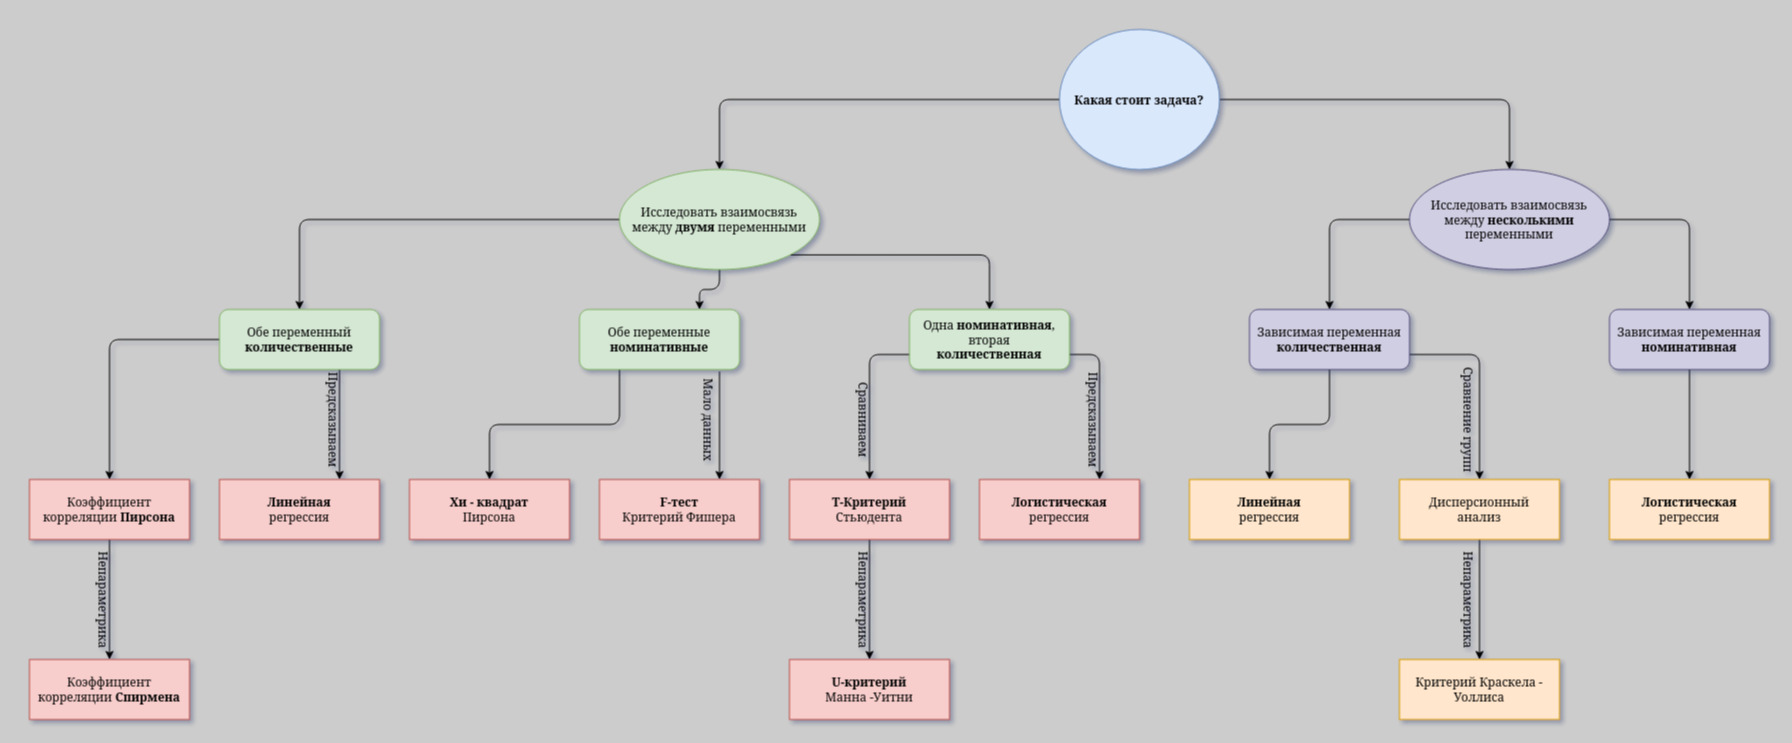

# Анализ номинативных данных

## Формулировка проблемы

*Типы задач* при анализе номинативных данных:

1. **Проверка гипотезы о распределении номинативной переменной.** *Например: нулевая гипотеза говорит нам о том, что 3 политические партии одинаково популярны среди населения. Мы опрашиваем определенное кол-во человек, строим график и смотрим, насколько отличаются эмпирические значения от предполагаемых.*
2. **Проверка гипотезы о взаимосвязи двух номинативных переменных.** *Например: у нас есть 2 лекарства $A$ и $B$*, мы собрали данные от людей о том, помогло они им или нет ($1$ - помогло, $0$ - не помогло). Проверяем, одинаково ли помогают людям лекарства.* 
3. **Более сложные модели. (ЗП - номинативная, логистическая регрессия)** *Пример: у нас есть данных о выздоровевших людях ($1$ - выздоровели, $0$ - не выздоровели)*, и мы хотим узнать, от чего зависит выздоровление (лекарства, возраст, пол ...)

##  Расстояние Пирсона

Допустим мы провели опыт, где определенное кол-во раз подбрасывали монетку. Для этого опыта:

* $N = 60$, где $N$ - кол-во подбрасываний
* Решка выпала 20 раз ($O_{р} = 20$) *(O - observed, наблюдаемое значение)*
* Орел выпал 40 раз ($O_{о} = 40$)
* $H_0: P_{р} = P_{о} = 0.5$
* $H_1: P_{р} \neq P_{о} \neq 0.5$

Посчитаем ожидаемые значения *(E - expected, ожадаемые)*:

* $E_{o} = E_{p} = 30$

Мы можем посчитать сумму квадратов отклонений ($d^2 = (O_p - E_p)^2 + (O_o - E_o)^2$), однако это будет бессмысленно, так как одно и то же значение может характеризовать как довольно значительные, так и несущественные расхождения между ожидаемыми и наблюдаемыми частотами. Например, для пар чисел *(20 и 40)* и *(1020 и 1040)* значение будет одним и тем же, хотя очевидно, что эти пары сильно отличаются.

Поэтому мы считаем немного по другой формуле: $\frac{(O_о - E_о)^2}{E_о} + \frac{(O_р - E_р)^2}{E_р}$


Эта формула -  **расстояние хи-квадрат Пирсона:**

> $\chi^2 = \sum^n_{i=1}\frac{(O_i - E_i)^2}{E_i}$

Она характеризует, *насколько сильно наблюдаемые частоты признака отклоняются от ожидаемых частот признака.* Этот показатель *подчиняется распределению Хи-квадрат.*

In [ ]:
# chi-square

O = [20, 40]

stats.chisquare(O)

Power_divergenceResult(statistic=6.666666666666667, pvalue=0.009823274507519235)

In [ ]:
# chi-square with not equal expected frequaences

O = [18, 55, 27]
E = [25, 50, 25]

stats.chisquare(f_obs=O, f_exp=E)

Power_divergenceResult(statistic=2.62, pvalue=0.26982005638468687)

## Распределение Хи-квадрат Пирсона

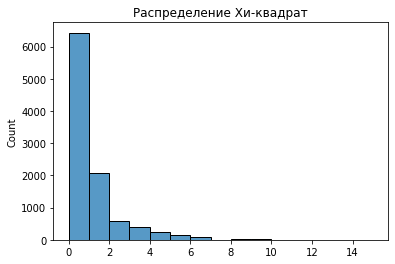

In [ ]:
# распраделение Хи-квадрат: 10000 экспериментов по 60 подбрасываний

y = []

for i in range(10000):
    x = []
    for i in range(60):
        x.append(random.randint(0, 1))
    y.append(stats.chisquare([x.count(0), x.count(1)])[0])

sns.histplot(y, binwidth=1)
plt.title('Распределение Хи-квадрат')
plt.show()

**Распределение Хи-квадрат с $k$ степенями свободы** - это распределение суммы квадратов $k$ независимых стандартных нормальных случайных величин.

Для распределения Хм-квадрат с 2 степенями свободы ($df = 2$), критическое значения для $p < 0.05$ равняется $5.99$. Это значит, что *$95%$ всех значений $\chi^2$ меньше или равны $5.99$.*

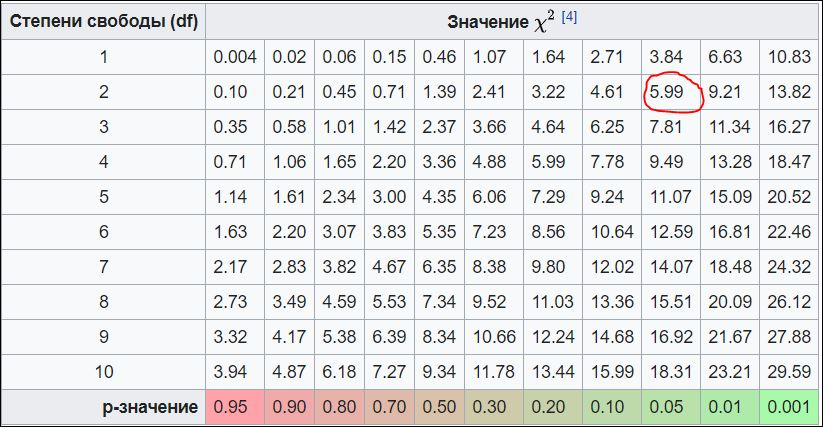

Чем больше степеней свободы, тем больше распределение "уходит вправо". С увеличением числа степеней свободы распределение будет *стремиться к нормальному.*

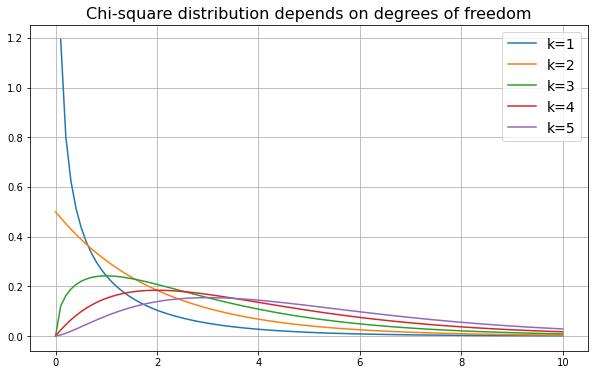

In [ ]:
plt.figure(figsize=(10, 6))
df_s = 5

x = np.linspace(0, 10, 100)

for i in range(df_s):
    df = i + 1
    plt.plot(x, stats.chi2.pdf(x, df), label=f'k={df}')

plt.legend(bbox_to_anchor=(1, 1), fontsize=14)
plt.title('Сhi-square distribution depends on degrees of freedom', fontsize=16)
plt.grid()
plt.show()

## Расчет p-уровня значимости

*Вернемся к примеру с монеткой:* так как мы знаем общее кол-во подбрасываний, то, зная кол-во выпадений решки, мы можем определить кол-во выпадений орла, и наоборот. А значит, что независимым тут будет только одно из двух нормальных распределений и **степень свободы Хи-квадрат распределения будет равна одному.**

In [ ]:
# Какая доля наблюдений лежит в диапазоне от 2 до 4 у распределения хи-квадрат с двумя степенями свободы?

a=stats.chi2.cdf(2 , 2)
b=stats.chi2.cdf(4 , 2)

c=b-a
c

0.23254415793482963

In [ ]:
# рассчитать p-value

O = [10, 10, 10, 5, 10, 15]

stats.chisquare(O)

Power_divergenceResult(statistic=5.0, pvalue=0.4158801869955079)

In [ ]:
# рассчитать chi-square

O = [10, 30, 50]

stats.chisquare(O)

Power_divergenceResult(statistic=26.666666666666668, pvalue=1.61959679231261e-06)

In [ ]:
# рассчитать p-value

O = [15, 9]

stats.chisquare(O)

Power_divergenceResult(statistic=1.5, pvalue=0.22067136191984324)

In [ ]:
# рассчитать p-value

N = 1500
percent1 = 53

o1 = N / 100 * percent1
o2 = N - o1

O = [o1, o2]

stats.chisquare(O)

Power_divergenceResult(statistic=5.4, pvalue=0.02013675155034633)

## Анализ таблиц сопряженности

Допустим, у нас есть две номинативные переменные:

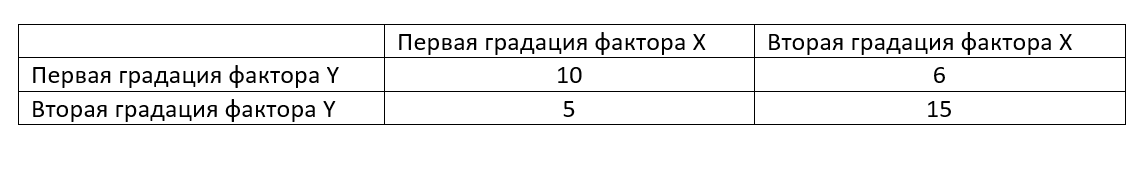

$H_0$: распределение не отличается от ожидаемого

$H_1$: распределение отличается от ожидаемого *(2 переменные взаимосвязаны между собой)*



---

Сначала рассчитаем все значения:

$X_1: 15$

$X_2: 21$

$Y_1: 16$

$Y_2: 20$

$total: 36$

**Расчет ожидаемых значений:**

Посчитаем частоту фактора $X$:

$X_1: \frac{15}{36} = \frac{5}{12}$

$X_2: \frac{7}{12}$

Если мы принимаем нулевую гипотезу о том, что факторы никак друг с другом не связаны, тогда градации фактора $X$ должны с равной частотой наблюдаться в градациях фактора $Y$:

$X_1Y_1 = \frac{5}{12} \cdot 16 = \frac{20}{3} = 6.67$

$X_2Y_1 = \frac{7}{12} \cdot 16 = \frac{28}{3} = 9.33$

$X_1Y_2 = \frac{5}{12} \cdot 20 = \frac{25}{3} = 8.33$

$X_2Y_2 = \frac{7}{12} \cdot 20 = \frac{35}{3} = 11.67$


То есть **формула расчета ожидаемых значений**:

> $f_{i,j} = \frac{f_i \cdot f_j}{N}$


In [ ]:
# расчет ожидаемых значений

observed = [(10, 6), (5, 15)]

stats.chi2_contingency(observed)

(3.715714285714286, 0.053902557169387154, 1, array([[ 6.66666667,  9.33333333],
        [ 8.33333333, 11.66666667]]))

**Расчет числа степеней свободы:**

Зная суммы по столбцам и строками и общую сумму в таблице 2 х 2, мы можем посчитать оставшиеся значения ячеек, зная только значений *ОДНОЙ* ячейки, поэтому $df = 1$.

**Общая формула:**

> $df = (n-1)(m-1)$, где $n$ - число строк, $m$ - число столбцов

---

Для таблицы 2 x 2 также применяется **поправка Йетса**. Так как распределение $\chi^2$ непрерывно, а вычисляемые значения дискретны, увеличивается шанс получить ошибку первого рода (ошибочное отвержение нулевой гипотезы), поэтому нужно при расчете $\chi^2$ нужно сделать еще вычитание. *Обычно используется, когда некоторые ожидаемые частоты меньше 10:*

> $\chi^2_{Yates} = \sum\frac{(|f_o-f_e|)^2}{f_e}$

In [ ]:
observed = [[15, 9], [11, 6]]
chi2_value, p_value, df, expected_array = stats.chi2_contingency(observed, correction=True) # correction=True - поправка Йейтса, стоит по умолчанию
p_value

0.8535442239746989

*Условия применения Хи-квадрата Пирсона:*

* Все наблюдения независимы
* Минимальное значение ожидаемых частот больше 5

In [ ]:
# find p-value

observed = [(20, 15), (11, 12), (7, 9)]

chi2_value, p_value, df, expected_array = stats.chi2_contingency(observed, correction=True) # correction=True - поправка Йейтса, стоит по умолчанию
p_value

0.6205162173513055

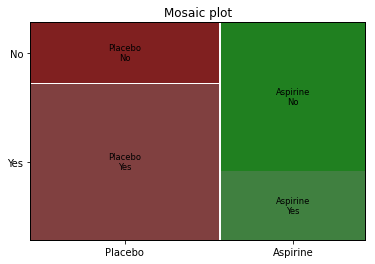

In [ ]:
tuples = list(product(['Placebo', 'Aspirine'], ['Yes', 'No']))
index = pd.MultiIndex.from_tuples(tuples)
data = pd.Series([18,7,6,13], index=index)
mosaic(data, title='Mosaic plot')
plt.show()

## Точный критерий Фишера

* При анализе четырехпольных таблиц ожидаемые значения в каждой из ячеек должны быть не менее 10. 

* В том случае, если хотя бы в одной ячейке ожидаемое явление принимает значение от 5 до 9, критерий хи-квадрат должен рассчитываться с **поправкой Йейтса**.

* Если хотя бы в одной ячейке ожидаемое явление меньше 5, то для анализа должен использоваться точный **критерий Фишера** (В случае анализа многопольных таблиц ожидаемое число наблюдений не должно принимать значения менее 5 более чем в 20% ячеек).


---

Допустим, у нас есть следующие данные:

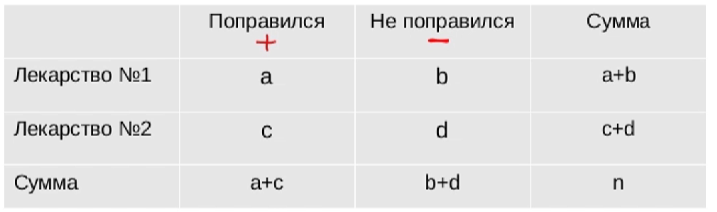

И нам надо понять, есть ли разница между лекарствами. Если есть ожадемые значения меньше 5, Можно посчитать *точный критерий Фишера (Гипергеометрический критерий, Hypergeometric test)*.

**Формула p-value для точного критерия Фишера:**

> $P = \frac{C^a_{a+b}\cdot C^c_{c+d}}{C^{a+c}_n}$

Полный вывод формулы: [тык](https://stepik.org/lesson/26447/step/3?unit=8328)

Но нельзя забывать про то, что надо будет еще посчитать p_value для таких же или более сильных отклонений данных ("перекосов"), а потом сложить их и получить p-value.

In [ ]:
# точный критерий Фишера

odds_ratio, p_value = stats.fisher_exact([[1, 3], [3, 1]])  # odds_ratio - отношение шансов
p_value

0.48571428571428527

# Логистическая регрессия и непараметрические методы

## Логистическая регрессия. Постановка задачи.

*ЗП* - номинативная переменная с двумя градациями (0, 1)

**Logit transformation (from probability to odds to log of odds):**

Сначала берем $P$ - вероятность успеха события ($Y=1$).

> $P = \frac{count(+)}{N}$

Затем считаем **шанс (odds)**  - отношеник вероятности успеха к вероятности неудачи.

> $odds = \frac{P}{1-P} = \frac{count(+)}{count(-)}$

Дальше просто берем **натуральный логарфим:**

> $ln(odds) \in [-\infty;+\infty]$

Таким образом мы сделали так, что наша ЗП может принимать не 2 значения (0 и 1), а все значения на промежутке от $-\infty$ до $+\infty$.

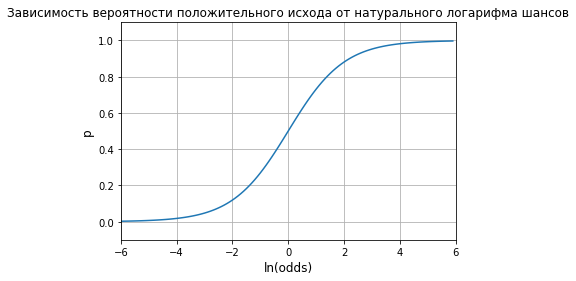

In [ ]:
# x - логарифм шансов
x = np.arange(-6, 6, 0.1)

# y - вероятность положительного исхода
y = np.exp(x) / (1 + np.exp(x))

plt.plot(x, y)
plt.grid()
plt.xlim(-6, 6)
plt.ylim(-0.1, 1.1)
plt.title('Зависимость вероятности положительного исхода от натурального логарифма шансов', fontsize=12)
plt.xlabel('ln(odds)', fontsize=12)
plt.ylabel('p', fontsize=12)

plt.show()

## Модель без предикторов. Intercept only model

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
titanic = pd.read_csv('gdrive/MyDrive/Colab Notebooks/CSV_files/titanik_full_data (1).csv', sep='\t')

In [ ]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
logit_res = sf.glm(formula='Survived ~ 1', data=titanic, family=sm.families.Binomial()).fit()

In [ ]:
logit_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                 1309
Model:                            GLM   Df Residuals:                     1308
Model Family:                Binomial   Df Model:                            0
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -867.57
Date:                Tue, 12 Jul 2022   Deviance:                       1735.1
Time:                        13:43:36   Pearson chi2:                 1.31e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5007      0.057     -8.780      0.000      -0.612      -0.389
==============================================================================
"""

**Intercept** - натуральнай логарифм шансов полоэительного исхода.

Чтобы расчитать шанс положительного исхода нужно рассчитать экспоненту значения *intercept*.

## Модель с одним номинативным предиктором

In [ ]:
logit_res2 = sf.glm(formula='Survived ~ C(Sex)', data=titanic, family=sm.families.Binomial()).fit()

In [ ]:
logit_res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                 1309
Model:                            GLM   Df Residuals:                     1307
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -539.84
Date:                Tue, 12 Jul 2022   Deviance:                       1079.7
Time:                        13:43:47   Pearson chi2:                 1.31e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.5588      0.122     12.752      0.000       1.319       1.798
C(Sex)[T.male]    -3.4660      0.160    -21.713      0.000      -3.779      -3.153
==================================================================================
"""

Коэффициент при *Intercept* - логарифм шанса выжить для женщин.

Коэффициент при *Sex[Male]* - логарифм отношения шансов выжить мужчин и женщин.

---

Чтобы сравнить модели, лучше использовать **информационный критерий Акаике (AIC).** Чем он ниже, тем лучше модель (сам по себе он ничего не значит).

In [ ]:
print(logit_res.aic)
print(logit_res2.aic)

1737.1334135878446
1083.684079405639


Вторая модель лучше, чем первая.

## Модель с двумя номинативными предикторами


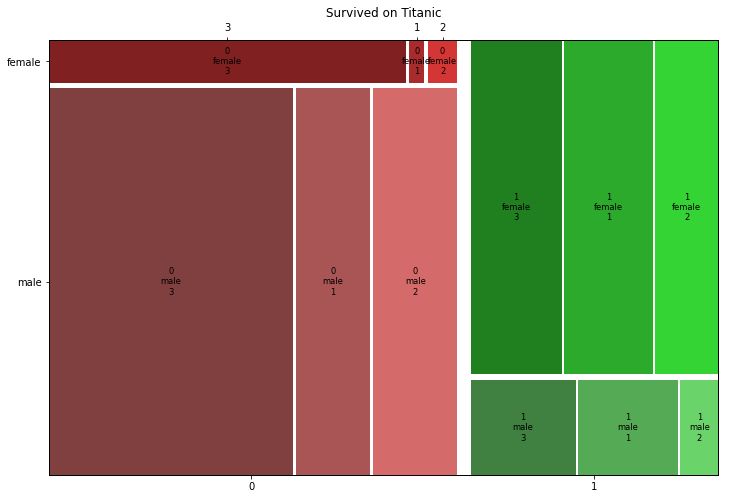

In [ ]:
plt.rcParams['figure.figsize']=(12, 8)
mosaic(titanic, ['Survived', 'Sex', 'Pclass'], gap = 0.02, title='Survived on Titanic')
plt.show()

In [ ]:
logit_res3 = sf.glm(formula='Survived ~ C(Sex) * C(Pclass)', data=titanic, family=sm.families.Binomial()).fit()

In [ ]:
logit_res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                 1309
Model:                            GLM   Df Residuals:                     1303
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -486.58
Date:                Tue, 12 Jul 2022   Deviance:                       973.16
Time:                        16:47:24   Pearson chi2:                 1.31e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         3.8501      0.583      6.599      0.000       2.707       4.994
C(Sex)[T.male]                   -4.9413      0.608     -8.122      0.000      -6.134      -3.749
C(Pclass)[T.2]                   -1.0367      0.719     -1.442      0.149      -2.446       0.373
C(Pclass)[T.3]                   -3.1570      0.601     -5.252      0.000      -4.335      -1.979
C(Sex)[T.male]:C(Pclass)[T.2]    -0.0758      0.782     -0.097      0.923      -1.609       1.458
C(Sex)[T.male]:C(Pclass)[T.3]     1.9980      0.644      3.104      0.002       0.736       3.260
=================================================================================================
"""

$intercept$ - логарифм шанса выжить для женщины в 1м классе

$Sex[Male]$ - логарифм отношений шансов выжить для мужчин и женщин в 1м классе

> $log(\frac{odds_{male}}{odds_{female}}) = log(odds_{male}) - log(odds_{female})$

Можно интрепретировать коэффициент как цену перехода с одной градации фактора на другую.

$Pclass[2]$ - логарифм отношений шансов выжить для женщин во 2м и в 1м классе

## Взаимодействие номинативных предикторов

$SexMale:Pclass[2]$ - разность логарифмов отношений шансов, расчитанного для мужчин и женщин в 1м и 2м классе. Отвечает на вопрос, *как проявляется зависимость, выжил ли человек или нет, в зависимости от пола.* ($log(\frac{odds_{m2}}{odds_{f2}}) - log(\frac{odds_{m1}}{odds_{f1}})$)

---

Итого, получаем следующее уравнение:

> $log(\frac{p}{1-p}) = 3.9 - 4.94 \cdot male - 1.04 \cdot 2class - 3.16 \cdot 3class - 0.08 \cdot male \cdot 2class + 2.00 \cdot male \cdot 3class$

Посчитаем шансы выжить для мужчины из 3 класса:

$log(\frac{p}{1-p}) = 3.9 - 4.94 - 3.16 + 2 = -2.2, \space p = 0.17$


---


Все методы статистического анализа можно разделить на 2 группы: первая - те, которые можно решить с помощью линейной регрессии, вторая - можно решить с помощью логистической регрессии.

**t-тест** можно заменить *линейной регрессией*, если в качестве зависимой переменной взять метрическую переменную, а в качестве предиктора - разделение на группы, или *логистической регрессией*, если в качестве зависимой переменной взять разделение на группы, а в качестве предиктора - количественную переменную.

**Корреляция** - это *линейная регрессия* с одним предиктором, а **анализ таблиц сопряженности** - это *логистическая регрессия* с одним предиктором.

## Когда нужно использовать непараметрические методы и почему?

*Основные требования к t-тесту:*

* Независимость каждого из наблюдений
* Гомогенносить дисперсий (желательно)
* Нормальное распределение исследуемого признака в ГС
* Объем выборки $(N > 30)$

---

Проверка на *нормальность* - **Shapiro-Wilk test**

$H_0$: выборка извлечена из нормально распределенной ГС

Если корреляция на графике *qq-plot* превышает $0.95$, это допустимое отклонение реальных данных от идеальных.

---

Самым популярным непараметрическим критерием для сравнения двух групп является **U-критерий Манна — Уитни**.

Для каждой из выборок рассчитывается показатель:

> $U_1 = R_1 - \frac{n_1(n_1+1)}{2}$

> $U_2 = R_2 - \frac{n_2(n_2+1)}{2}$

$R_1, R_2$ - суммы рангов.

Наименьшее из полученных значений выступает в качестве статистики теста. 

*Когда разумно применять вместо t - теста: *

1. Распределение хотя бы в одной из выборок значительно отличается от нормального. 
2. Есть заметные выбросы в данных. 
3. В некоторых задачах мощность теста даже выше, чем t-критерия (например, когда в обеих выборках наблюдается заметная асимметрия в одинаковом направлении). 

*Неразумно применять:* 

1. Выборки разного размера, с различным направлением асимметрии.  


---

Если есть основания считать, что нарушаются требования одновременно и гомогенности дисперсии, и нормальности распределения, вместо дисперсионного анализа лучше использовать его непараметрический аналог - **Критерий Краскела - Уоллиса (Kruskal - Wallis)**.

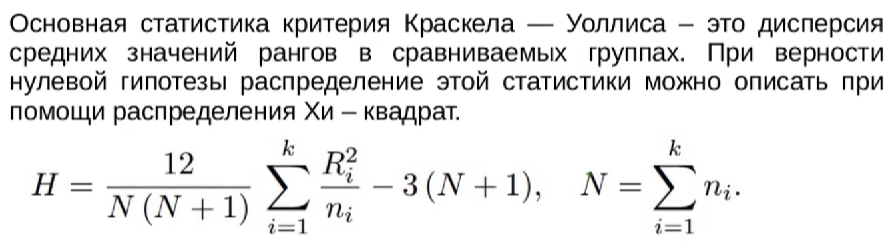

**Какой тест использовать?**

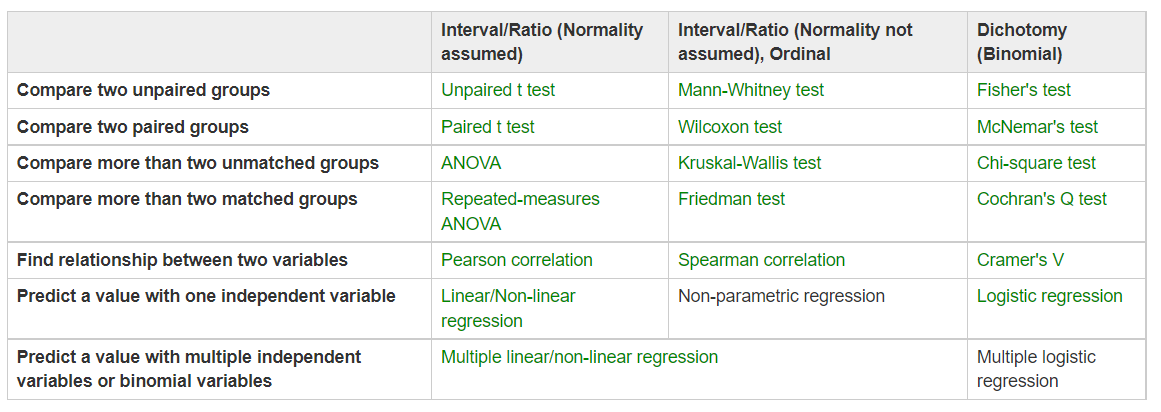

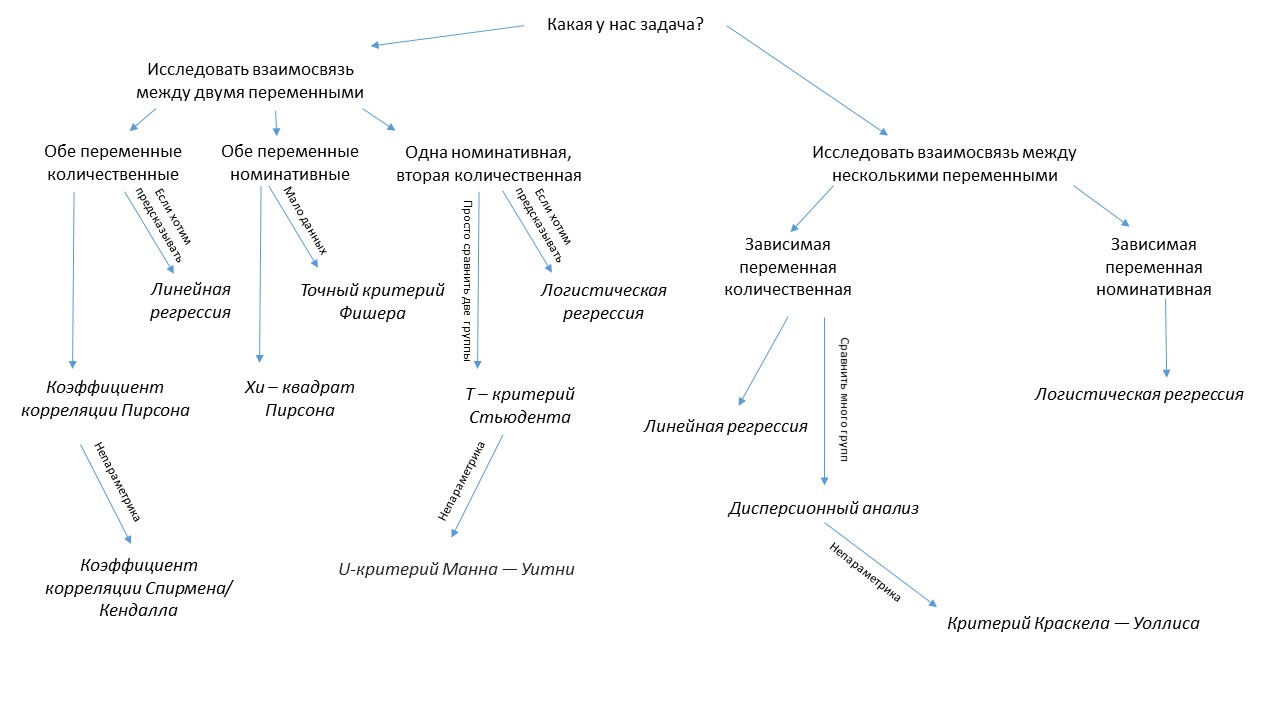

# Кластерный анализ и метод главных компонент

## Кластерный анализ методом k-средних

*Кластерный анализ* позволяет ответить на вопрос, есть ли среди наших наблюдений кокое-то распеделение по группам (кластерам), а с помощью метода главных компонент мы научимся группировать наши переменные, будем смотреть, можно ли еще как-то сократить наши данные.

---

Метод **k-means**:

1. Решаем, на сколько кластеров будем делить наблюдения
2. Случайно выбираем начальные позиции центроидов кластера
3. Выводим центроиды на наилучшие позиции

Поподробнее про 3 пункт:

* Для каждого из начальных центроидов выбираем точки, которые находятся ближе к этому центроиду, чем ко все другим.
* Для этих точек рассчитываем новые значения центроидов.
* Повторяем эти пункты до того момента, пока на каком-то этапе ни одна точка не перейдет из зоны одного центроида в зону другого.

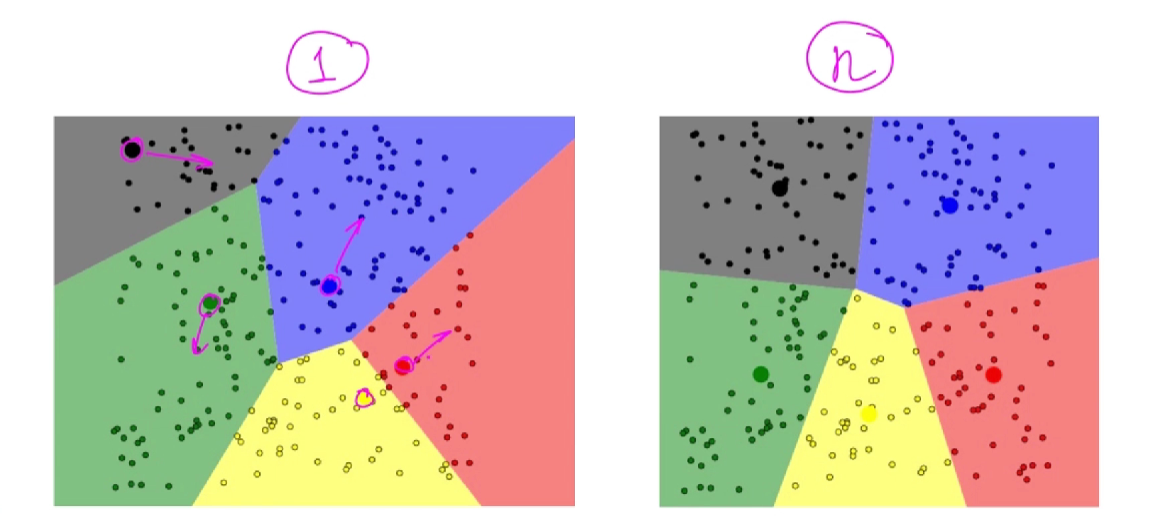

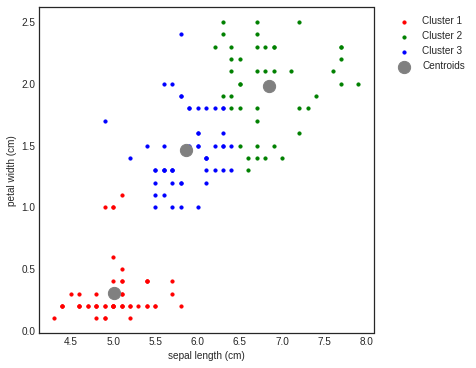

In [ ]:
plt.figure(figsize=(6, 6))
plt.style.use('seaborn-white')

# грузим данные 
data = load_iris()
df = pd.DataFrame(data.data, columns=data.feature_names)
X = df[['sepal length (cm)','petal width (cm)']].values

# определяем количество кластеров (равно количеству цветов в легенде)
clusters =('red', 'green', 'blue')
n_clusters = len(clusters)

kmeans = KMeans(n_clusters=n_clusters, init ='k-means++', max_iter=300, n_init=10, random_state=0 )
y_kmeans = kmeans.fit_predict(X)

# отрисовываем группы
for i, color in enumerate(clusters):
    plt.scatter(X[y_kmeans==i, 0], X[y_kmeans==i, 1], s=10, c=color, label=f'Cluster {i+1}')
# орисовываем центроиды
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=150, c='grey', label='Centroids')

plt.xlabel('sepal length (cm)')
plt.ylabel('petal width (cm)')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()

## Как определить максимальное число кластеров?

> **Внутригрупповая сумма квадратов (within-cluster sum of squares)** - сумма квадратов отклонений каждого наблюдения от центроида кластера.

> **Общая внутригрупповая сумма квадратов (total within-cluster sum of squares)** - сумма внутригрупповых сум квадратов каждого кластера.

---

*Идея:*
если добавление еще одного кластера в наши данные значительно понижает общую сумму квадратов, это означает, что в увеличении числа кластеров есть смысл.

In [ ]:
points = np.array([[1,2], [2,1], [2,2], [1,3], [6,7], [6,5], [7,8], [8,8]], dtype=float)

# Список найденных центроидов и дисперсия
centroids, disp = kmeans(points, 1)

# Перебираем найденные центроиды, метод <kmeans> всегда возвратит двумерный массив
# оба параметра метода <cdist> должны быть двумерными массивами
results = (sum(cdist(points, [centroid,])**2) for centroid in centroids)


list(results)[0][0]


116.875

In [ ]:
# Запишем координаты точек в виде массива numpy
X = np.array([[-3, 3], [1, 4], [2, 6], [3, 8], [5, 2], [6, 11], [7, 1]])
# Обучим модель KMeans на нашем массиве с одним кластером
kmeans = KMeans(n_clusters=1).fit(X)
# Выведем координаты центроида данного кластера
print(kmeans.cluster_centers_)
# Выведем сумму квадратов расстояний точек от центроида = аттрибут модели kmeans
print(kmeans.inertia_)

[[3. 5.]]
146.0


## Иерархическая кластеризация

* Рассчитывает расстояния между всеми точками
* Постепенно группирует точки в кластеры, пока не объединит все точки в один кластер

*Метод одиночной связи (Центроидный метод) (Centroid Linkage)*: [тык](https://stepik.org/lesson/27110/step/2?unit=8682)

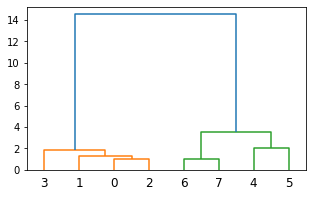

In [ ]:
points = np.array([[1,2], [2,1], [2,2], [1,3], [6,7], [6,5], [7,8], [8,8]], dtype=float)

q = linkage(points, 'ward')
fig = plt.figure(figsize=(5, 3))
dn = dendrogram(q)

plt.show()

## Введение в метод анализа главных компонент

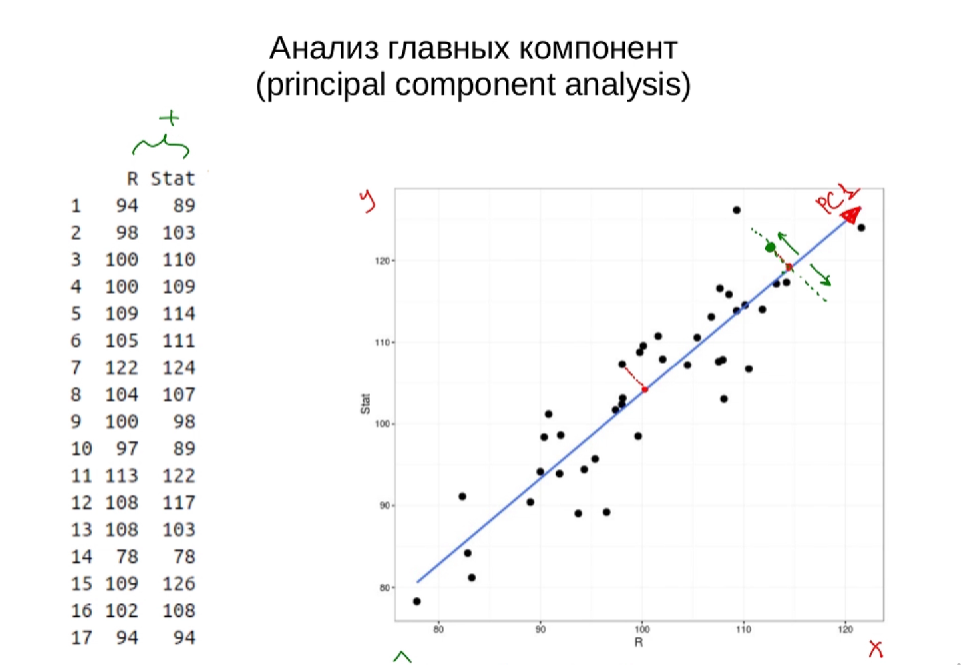

Суть метода в том, чтоб сделать из регрессионной прямой еще одну ось, на которую будут проецироваться значения. 

Добавляем вторую главную компоненту. Видим, что она объясняет всего 5% дисперсии.

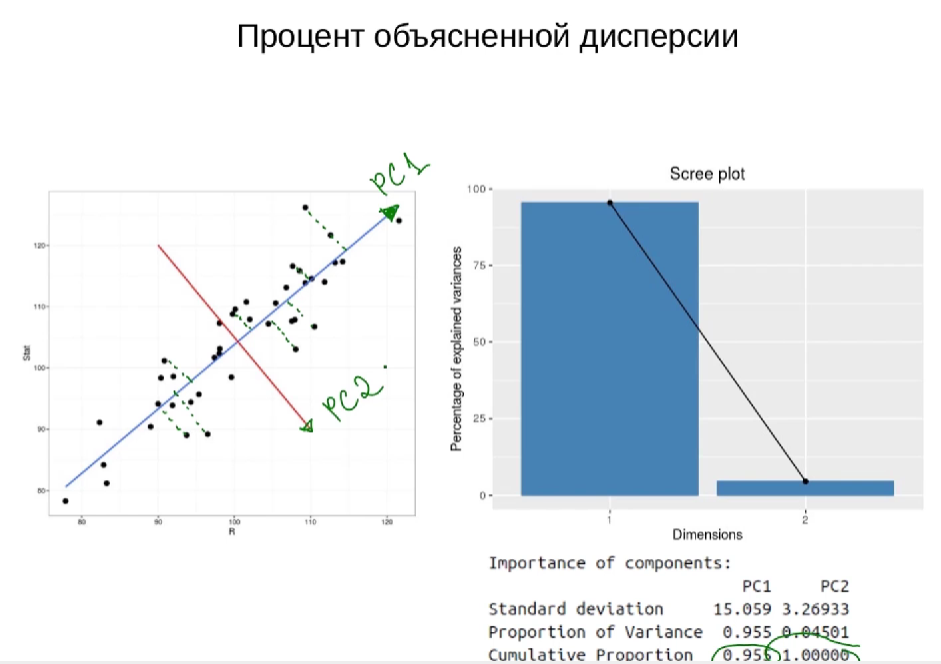

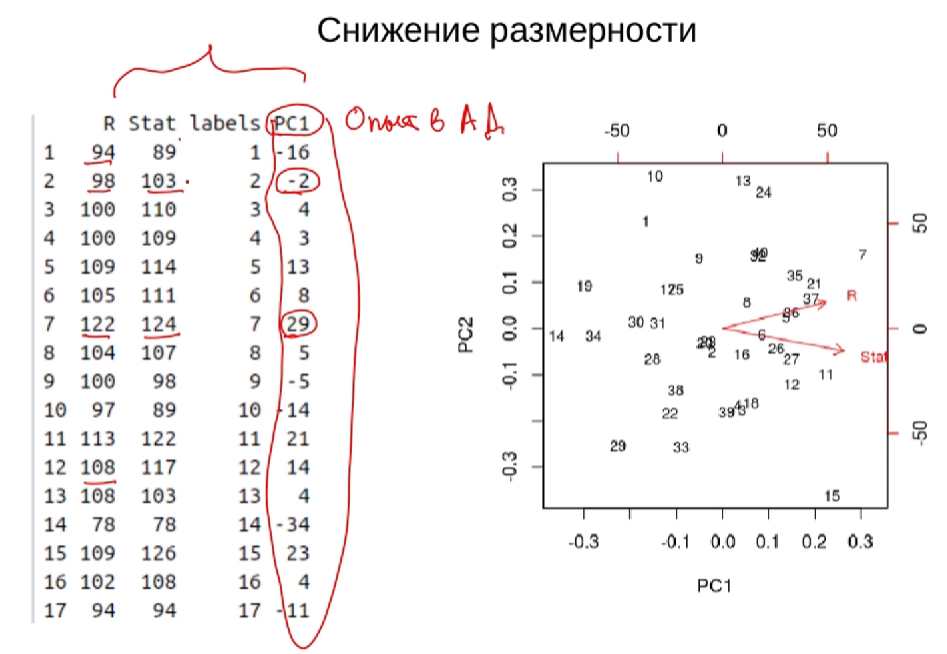

Теперь мы можем описать две переменный ОДНОЙ переменной (другой). Например, рост и вес человека можем описать одной переменной ("конституция тела").

Теперь при работе с датасетом мы можем заменить несколько переменных на одну.

---

Анализ главных компонент позволяет понять, каким оптимальным кол-вом компонент можно описать данные. По графику *biplot* можно понять, каким образом связаны друг с другом переменные (положительная / отрицательная корреляция).

# Полезные ссылки

* [Калькулятор p-уровня значимости](https://gallery.shinyapps.io/dist_calc ﻿)
* [Визуализация кластеризации](https://www.naftaliharris.com/blog/visualizing-k-means-clustering/)